# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix **where
each column is the concatenation of all feature vectors for a single image**.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
################################################################################
hyperparameters = [(lr,rs) for lr in learning_rates 
                       for rs in regularization_strengths]

for h in hyperparameters:
  classifier = LinearSVM()
  lr, rs = h
  _ = classifier.train(X_train_feats, y_train, learning_rate = lr, reg = rs, num_iters=1500)
  y_val_pred = classifier.predict(X_val_feats)
  y_train_pred = classifier.predict(X_train_feats)
  val_accuracy = np.mean(y_val_pred == y_val)
  train_accuracy = np.mean(y_train_pred == y_train)
  results[h] = (train_accuracy,val_accuracy)
  if (val_accuracy > best_val):
    best_val = val_accuracy
    best_svm = classifier                            #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.128408 val accuracy: 0.118000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.094714 val accuracy: 0.081000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.412510 val accuracy: 0.418000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.093306 val accuracy: 0.106000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.413939 val accuracy: 0.412000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.404041 val accuracy: 0.393000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.417980 val accuracy: 0.420000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.406714 val accuracy: 0.412000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.321714 val accuracy: 0.324000
best validation accuracy achieved during cross-validation: 0.420000


In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


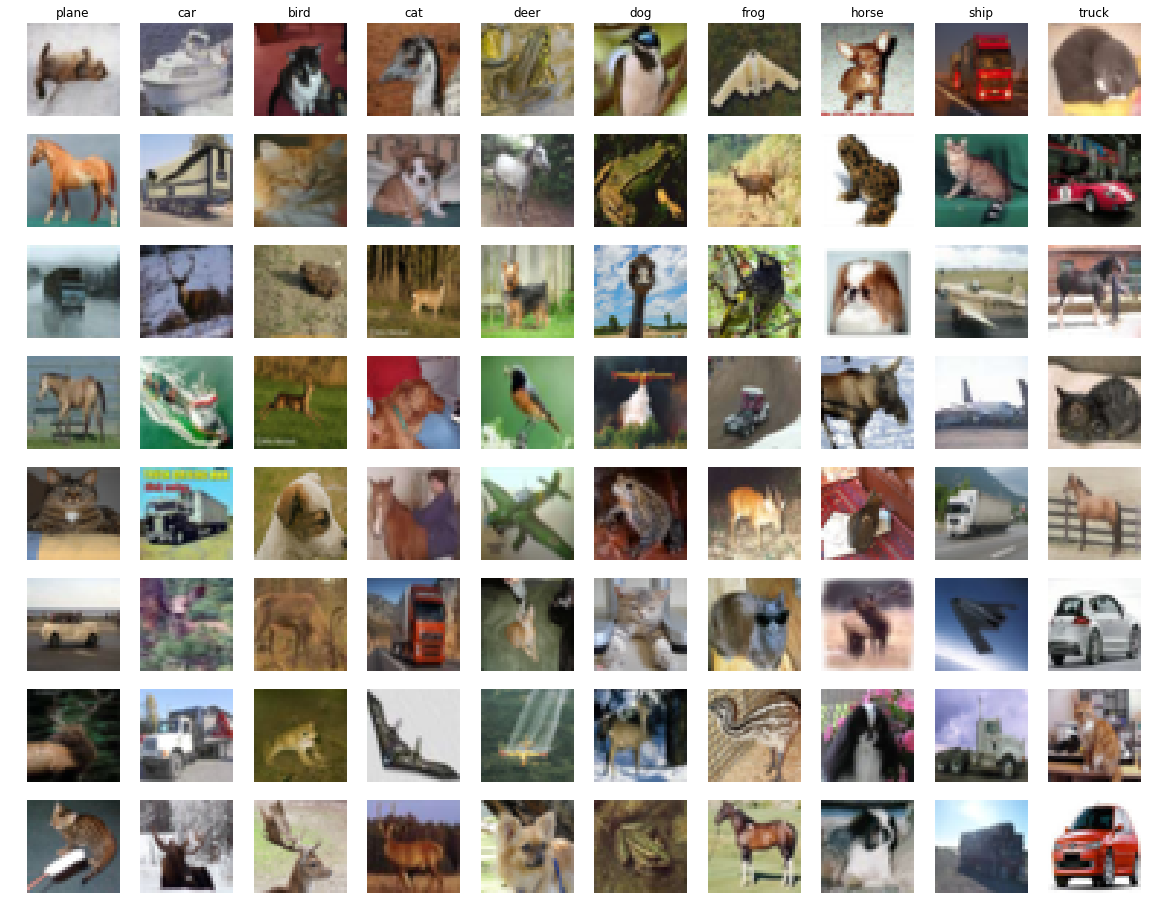

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)



(learning rate, reg) =  (1, 0.1)
Validation accuracy:  0.267

(learning rate, reg) =  (1, 0.01)
Validation accuracy:  0.503


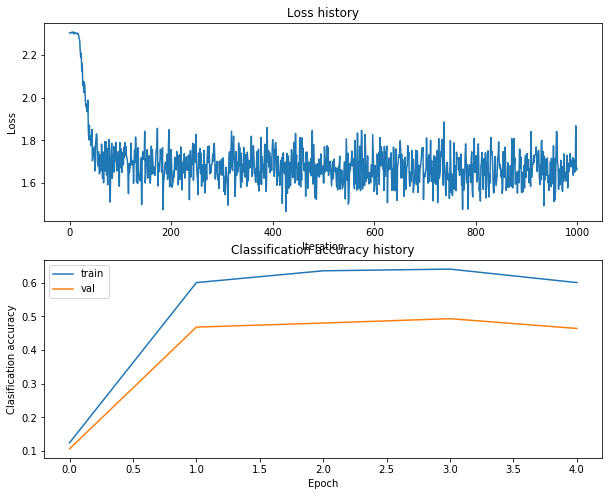


(learning rate, reg) =  (1, 0.001)
Validation accuracy:  0.579


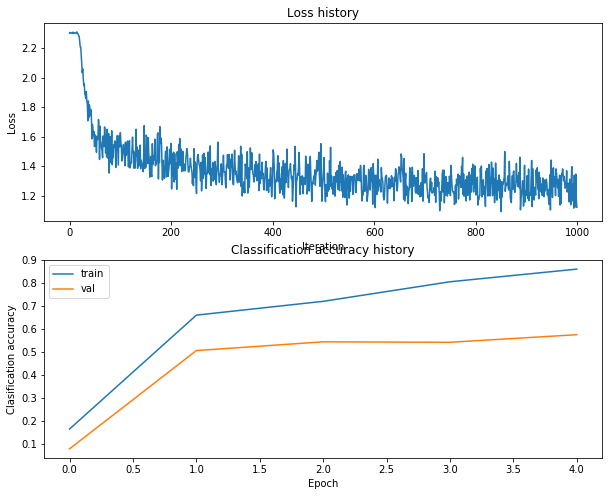


(learning rate, reg) =  (0.1, 0.1)
Validation accuracy:  0.296

(learning rate, reg) =  (0.1, 0.01)
Validation accuracy:  0.497

(learning rate, reg) =  (0.1, 0.001)
Validation accuracy:  0.522


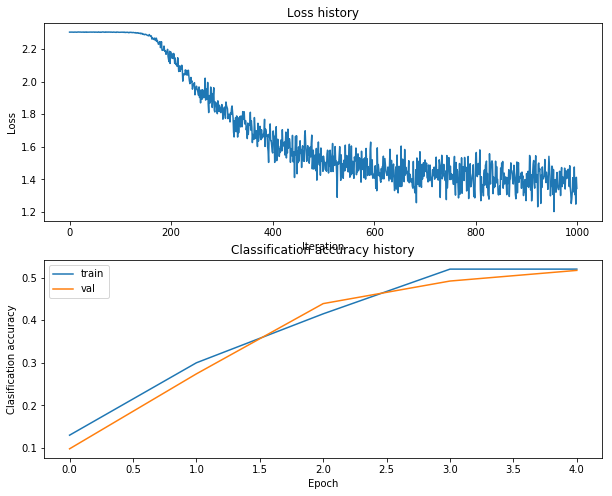


(learning rate, reg) =  (0.01, 0.1)
Validation accuracy:  0.112

(learning rate, reg) =  (0.01, 0.01)
Validation accuracy:  0.105

(learning rate, reg) =  (0.01, 0.001)
Validation accuracy:  0.109

(learning rate, reg) =  (0.001, 0.1)
Validation accuracy:  0.098

(learning rate, reg) =  (0.001, 0.01)
Validation accuracy:  0.098

(learning rate, reg) =  (0.001, 0.001)
Validation accuracy:  0.079

(learning rate, reg) =  (0.0001, 0.1)
Validation accuracy:  0.099

(learning rate, reg) =  (0.0001, 0.01)
Validation accuracy:  0.099

(learning rate, reg) =  (0.0001, 0.001)
Validation accuracy:  0.105

(learning rate, reg) =  (1e-05, 0.1)
Validation accuracy:  0.085

(learning rate, reg) =  (1e-05, 0.01)
Validation accuracy:  0.081

(learning rate, reg) =  (1e-05, 0.001)
Validation accuracy:  0.076


In [57]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_val = -1
best_stats = {}

learning_rates= [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
regs = [1e-1, 1e-2, 1e-3]

hyperparameters = [( lr, rs)  for lr in learning_rates for rs in regs]
results = {}

for h in hyperparameters: 
    (lr, rs) = h
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=rs)

    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    print()
    print("(learning rate, reg) = ", h )
    print('Validation accuracy: ', val_acc)

    if (val_acc > best_val):
        best_val = val_acc
        best_net = net
        best_stats = stats
        
    if (val_acc > 0.5):
        results[h] = val_acc
        plt.subplot(2, 1, 1)
        plt.plot(stats['loss_history'])
        plt.title('Loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        plt.subplot(2, 1, 2)
        plt.plot(stats['train_acc_history'], label='train')
        plt.plot(stats['val_acc_history'], label='val')
        plt.title('Classification accuracy history')
        plt.xlabel('Epoch')
        plt.ylabel('Clasification accuracy')
        plt.legend()
        plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################


(learning rate, reg) =  (0.520807406858571, 0.023750220341043536)
Validation accuracy:  0.44
Training accuracy:  0.52

(learning rate, reg) =  (1.2990513032833229, 0.017759450640700385)
Validation accuracy:  0.41
Training accuracy:  0.57

(learning rate, reg) =  (0.5529198381933884, 0.00043365070084003623)
Validation accuracy:  0.605
Training accuracy:  0.825


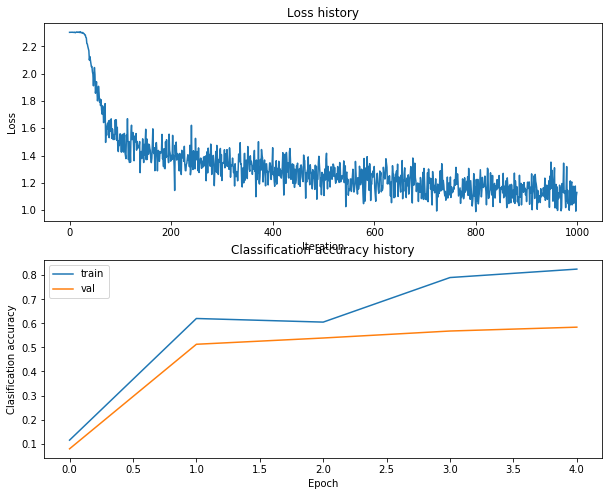


(learning rate, reg) =  (2.034881715264668, 0.006231091988890116)
Validation accuracy:  0.465
Training accuracy:  0.635

(learning rate, reg) =  (0.2125497034302378, 0.0008698365730077952)
Validation accuracy:  0.549
Training accuracy:  0.57

(learning rate, reg) =  (2.3472672271508084, 0.02030708509268217)
Validation accuracy:  0.422
Training accuracy:  0.59

(learning rate, reg) =  (0.2657425189439574, 0.000538988436402357)
Validation accuracy:  0.553
Training accuracy:  0.65


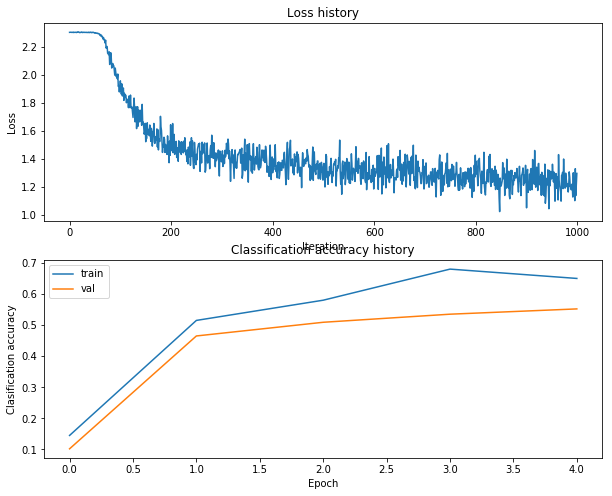


(learning rate, reg) =  (0.749370481690993, 0.0007757153317987437)
Validation accuracy:  0.585
Training accuracy:  0.785


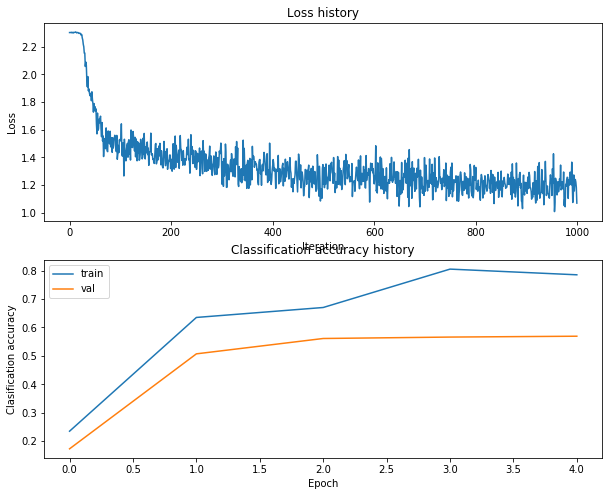


(learning rate, reg) =  (0.9839296916255098, 0.011897554057725402)
Validation accuracy:  0.484
Training accuracy:  0.61

(learning rate, reg) =  (0.3760504936537742, 0.005755373055638893)
Validation accuracy:  0.531
Training accuracy:  0.67

(learning rate, reg) =  (0.6397954258694019, 0.02626015386860697)
Validation accuracy:  0.453
Training accuracy:  0.54

(learning rate, reg) =  (0.5235647150495204, 0.002732295039624123)
Validation accuracy:  0.565
Training accuracy:  0.62


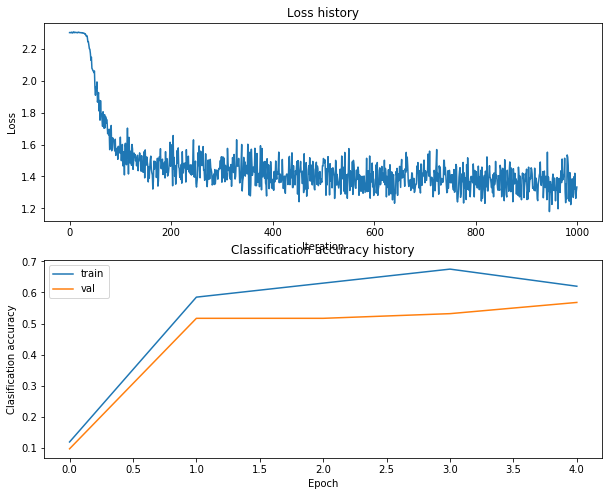


(learning rate, reg) =  (0.3877563383042608, 0.02038857644836444)
Validation accuracy:  0.492
Training accuracy:  0.57

(learning rate, reg) =  (0.08679810846370672, 0.0007082541842090369)
Validation accuracy:  0.503
Training accuracy:  0.56

(learning rate, reg) =  (0.210617965050397, 0.011133751176158398)
Validation accuracy:  0.503
Training accuracy:  0.545

(learning rate, reg) =  (2.2329459057887955, 0.0009061767870382208)
Validation accuracy:  0.533
Training accuracy:  0.895

(learning rate, reg) =  (0.20838812237887744, 0.0012181236513076087)
Validation accuracy:  0.537
Training accuracy:  0.61

(learning rate, reg) =  (1.7706339010107788, 0.006810072901262484)
Validation accuracy:  0.497
Training accuracy:  0.61

(learning rate, reg) =  (1.2787170231151213, 0.01164013160694444)
Validation accuracy:  0.472
Training accuracy:  0.63

(learning rate, reg) =  (0.8528029536018916, 0.031575062353403176)
Validation accuracy:  0.44
Training accuracy:  0.545

(learning rate, reg) =  (0.

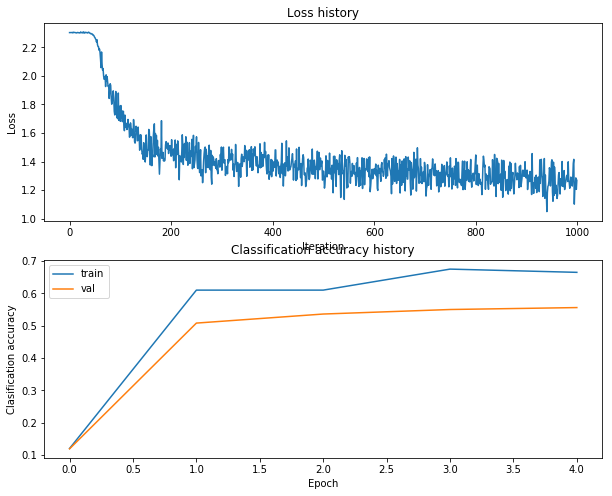


(learning rate, reg) =  (0.15004935118188323, 0.0025311484205371017)
Validation accuracy:  0.522
Training accuracy:  0.535

(learning rate, reg) =  (0.4810396230506967, 0.025830614805524163)
Validation accuracy:  0.417
Training accuracy:  0.555

(learning rate, reg) =  (0.40906263450387176, 0.0011764541359874537)
Validation accuracy:  0.574
Training accuracy:  0.71


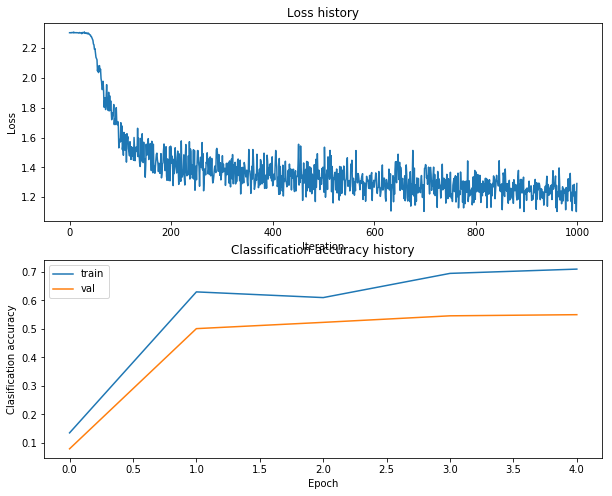


(learning rate, reg) =  (2.366071201503237, 0.017177470396144916)
Validation accuracy:  0.393
Training accuracy:  0.53

(learning rate, reg) =  (1.7074399994796163, 0.01796960223525783)
Validation accuracy:  0.447
Training accuracy:  0.61

(learning rate, reg) =  (0.6335714223676974, 0.004185200789817113)
Validation accuracy:  0.534
Training accuracy:  0.665

(learning rate, reg) =  (2.6992286426221583, 0.004145271699025315)
Validation accuracy:  0.509
Training accuracy:  0.74

(learning rate, reg) =  (0.5962128037809886, 0.009799453656101709)
Validation accuracy:  0.514
Training accuracy:  0.61

(learning rate, reg) =  (0.10845066699926255, 0.01609470476862628)
Validation accuracy:  0.484
Training accuracy:  0.47

(learning rate, reg) =  (2.367989795901888, 0.0003469862603948715)
Validation accuracy:  0.55
Training accuracy:  0.875

(learning rate, reg) =  (1.508271868161208, 0.0031959369626593354)
Validation accuracy:  0.534
Training accuracy:  0.785

(learning rate, reg) =  (0.3663

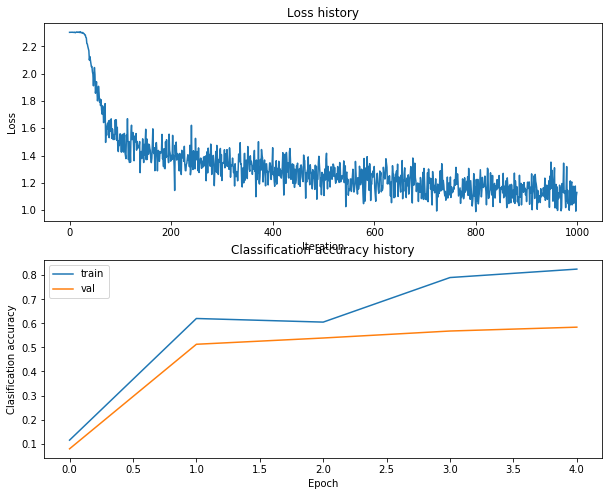

In [85]:
hyperparameters = []
results = {}
best_val = -1
best_stat = None
best_net = None
for i in range(50): 
    lr = 10 ** np.random.uniform(-1.1, 0.5)
    rs = 10 ** np.random.uniform(-3.5, -1.5)
    h = (lr, rs)
    hyperparameters.append(h)
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=rs)

    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    print()
    print("(learning rate, reg) = ", h )
    print('Validation accuracy: ', val_acc)
    print("Training accuracy: ", stats['train_acc_history'][-1])

    if (val_acc > best_val):
        best_val = val_acc
        best_net = net
        best_stats = stats
        best_hyper = h
        
    if (val_acc > 0.55):
        results[h] = val_acc
        plt.subplot(2, 1, 1)
        plt.plot(stats['loss_history'])
        plt.title('Loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        plt.subplot(2, 1, 2)
        plt.plot(stats['train_acc_history'], label='train')
        plt.plot(stats['val_acc_history'], label='val')
        plt.title('Classification accuracy history')
        plt.xlabel('Epoch')
        plt.ylabel('Clasification accuracy')
        plt.legend()
        plt.show()
        
print()
print ("Ploting the best: ", best_val)
print(best_val)
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [86]:
print(results)


{(0.5529198381933884, 0.00043365070084003623): 0.605, (0.2657425189439574, 0.000538988436402357): 0.553, (0.749370481690993, 0.0007757153317987437): 0.585, (0.5235647150495204, 0.002732295039624123): 0.565, (0.35575305125348355, 0.001475620287651343): 0.554, (0.40906263450387176, 0.0011764541359874537): 0.574}


In [87]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.575
